## Trying to implement Grad-Cam  
Following https://medium.com/@codetrade/grad-cam-in-pytorch-a-powerful-tool-for-visualize-explanations-from-deep-networks-bdc7caf0b282  

https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569 

https://medium.com/the-owl/gradcam-in-pytorch-7b700caa79e5  

Steps:
1. Preprocess the Input Image
2. Perform a Forward Pass
3. Identify the Target Layer
4. Backward Pass
5. Compute the Heatmap
6. Visualize the heatmap

In [7]:
import torch 
import numpy as np
import cv2
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image


In [120]:
%run setup.ipynb

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079


In [69]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# keep track of activations and gradients
activations = None
gradients = None
# hooks for capturing activations and gradients 
def forward_hook(module, args, output):
    global activations
    print("forward")
    activations = output
    print(f'Activations size: {activations.size()}')

def backward_hook(module, grad_input, grad_output):
    global gradients
    print("backward")
    gradients = grad_output
    print(f'Gradients size: {gradients[0].size()}') 

def create_heatmap(model, imgpath,label, transforms=image_transforms):
    #open image
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transforms(img).unsqueeze(0)
    # first forward pass
    #set model to evaluation mode
    model.eval()
    #capture activations and gradients
    # we're interested in layer4 of resnet
    fw_hook = model.layer4.register_forward_hook(forward_hook, prepend=False)
    bw_hook = model.layer4.register_full_backward_hook(backward_hook, prepend=False)

    # fw_hook = model.classifier.register_forward_hook(forward_hook, prepend=False)
    # bw_hook = model.classifier.register_full_backward_hook(backward_hook, prepend=False)

    output = model(img_tensor)
    _, pred = torch.max(output, 1)
    print("Prediction: ",class_labels[pred.item()])

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label)

    #identify target layer. we want to use last convolutional layer
    # target_layer = model.layer4[-1] # FIXME what layer
    # print(target_layer)

    
    # 4 backward pass
    # model.zero_grad() #zero gradients
    # output[:, pred].backward() #bw pass to compute gradients
    loss.backward()

    # Compute the weights
    pooled_gradients = torch.mean(gradients[0], dim=[0,2, 3])
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i].detach().cpu()

    # # Compute the Grad-CAM heatmap
    # heatmap = torch.sum(activations, dim=1).squeeze()
    # heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    # heatmap /= np.max(heatmap)
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach())
    fw_hook.remove()
    bw_hook.remove()
    return heatmap.detach()


In [10]:
def visualize_heatmap_wrong(heatmap, imgpath):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint(255 * heatmap)
    print(heatmap.dtype)
    print(heatmap.shape)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4,0)
    cv2.imshow("Grad-CAM", super_imposed_img)

In [23]:
model = load_and_prep_resnet50()
optimizer = get_optimizer(model)
loaded = torch.load("basemodel.tar")
unfreeze_layers(model)
model.load_state_dict(loaded["model"])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


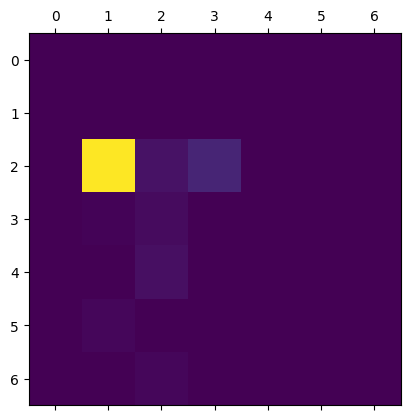

In [6]:
bluetitPath = "just-bird-data/withBackground/blueTit/(1).jpg"
# unfreeze_layers(model)
blueMap = create_heatmap(model=model, imgpath=bluetitPath, label=(torch.tensor([0])))

In [9]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

def notworkingproperly(imgpath, heatmap):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = image_transforms(img)
    # Create a figure and plot the first image
    fig, ax = plt.subplots()
    ax.axis('off') # removes the axis markers

    # First plot the original image
    ax.imshow(to_pil_image(img_tensor, mode='RGB'))

    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    # we need heatmap.detach() because it can't be converted to numpy array while
    # requiring gradients
    overlay = to_pil_image(heatmap, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)

    # Apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Plot the heatmap on the same axes, 
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax.imshow(overlay, alpha=0.4, interpolation='nearest') #

    # Show the plot
    plt.show()

In [100]:
from PIL import Image as eeee
from IPython.display import display, Image
def visualize_heatmap_on_top(imgpath, heatmat, filepath):
    image = cv2.imread(imgpath)
    heatmap2 = cv2.resize(heatmat.numpy(), (image.shape[0],image.shape[1]))
    heatmap2 = np.uint8(255*heatmap2)
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    cv2_img = np.array(image)
    open_cv_image = cv2_img[:, :, ::-1].copy()
    superimposed_img = heatmap2 * 0.9 + open_cv_image
    # cv2.imshow("bird",superimposed_img) #this just kills the kernel
    # cv2.imwrite('./map.jpg', superimposed_img)
    # display(eeee.fromarray(superimposed_img))
    cv2.imwrite(filepath, superimposed_img)
    display(Image(filepath))

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


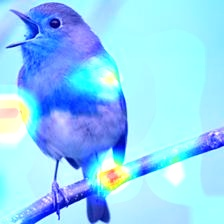

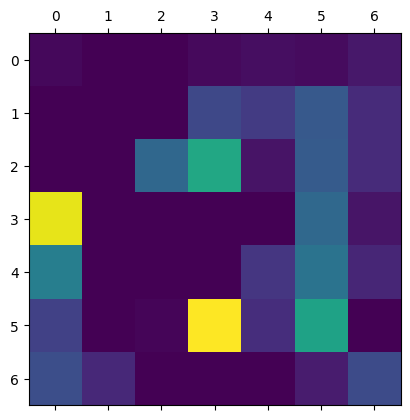

In [8]:
robinPath = "just-bird-data/withBackground/robin/(18).jpg"
# unfreeze_layers(model)
robinmat = create_heatmap(model=model, imgpath=robinPath, label=(torch.tensor([5])))
visualize_heatmap_on_top(robinPath, heatmat=robinmat, filepath="./robin.jpg")

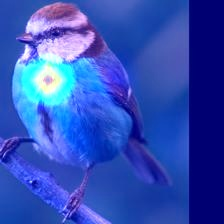

In [9]:
visualize_heatmap_on_top(bluetitPath, heatmat=blueMap, filepath="./map.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


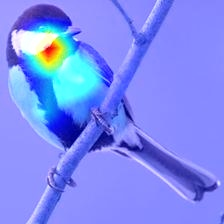

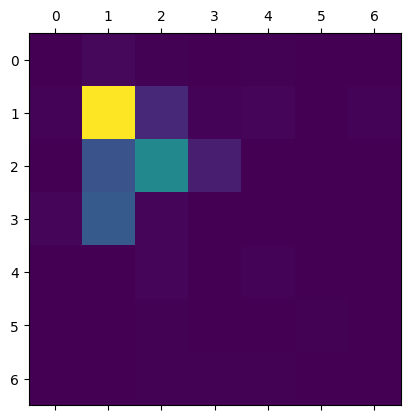

In [ ]:
greatPath = "just-bird-data/withBackground/greatTit/(38).jpg"
# unfreeze_layers(model)
greatmat = create_heatmap(model=model, imgpath=greatPath, label=(torch.tensor([5])))
visualize_heatmap_on_top(greatPath, heatmat=greatmat, filepath="./great.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


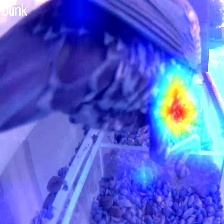

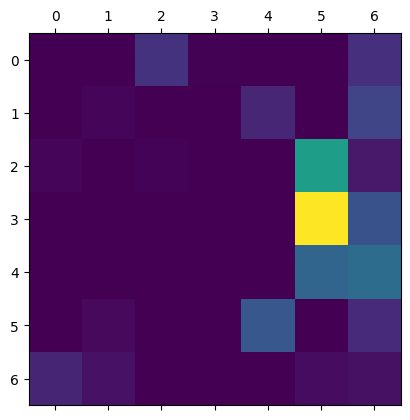

In [25]:
starlingFeeder = "feeder-data/starling/starling_738_34.png"
# unfreeze_layers(model)
starlingmat = create_heatmap(model=model, imgpath=starlingFeeder, label=(torch.tensor([5])))
visualize_heatmap_on_top(starlingFeeder, heatmat=starlingmat, filepath="./starlingFeeder.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


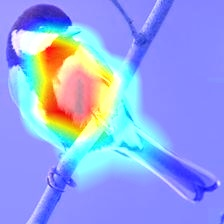

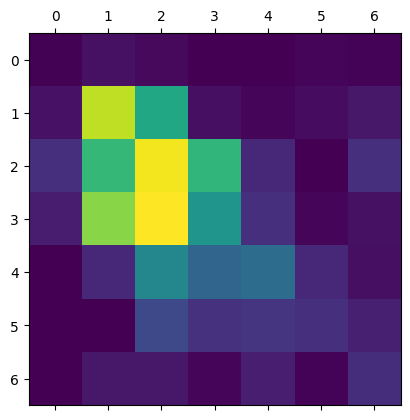

In [56]:
greatPath = "just-bird-data/withBackground/greatTit/(38).jpg"
# unfreeze_layers(model)
greatmat_vgg = create_heatmap(model=model, imgpath=greatPath, label=(torch.tensor([5])))
visualize_heatmap_on_top(greatPath, heatmat=greatmat_vgg, filepath="./greatvgg.jpg")

In [33]:
import torch.nn as nn 

# selecting layers from the model to generate activations
image_to_heatmaps = nn.Sequential(*list(model_vgg.features[:-4]))

Prediction: tensor([4])


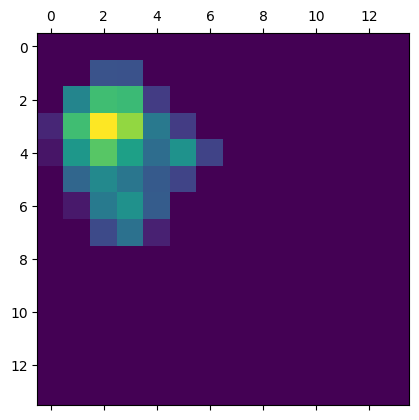

In [57]:
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

def compute_heatmap(model,img):
  model.eval()
  # compute logits from the model
  logits = model(img)
  # model's prediction 
  pred = logits.max(-1)[-1]
  # activations from the model
  activations = image_to_heatmaps(img)
  # compute gradients with respect to the model's most confident prediction
  logits[0, pred].backward(retain_graph=True)
  # average gradients of the featuremap 
  pool_grads = model.features[-3].weight.grad.data.mean((0,2,3))
  # multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pool_grads[i]
  # calculate mean of weighted activations
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()

  heatmap = F.relu(heatmap)

    # normalize the heatmap
  heatmap /= torch.max(heatmap)

    # draw the heatmap
  plt.matshow(heatmap.detach())

  return heatmap, pred

def upsampleHeatmap(map, image):
  # permute image
  image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
  # maximum and minimum value from heatmap
  m, M = map.min(), map.max()
  # normalize the heatmap
  map = 255 * ((map-m)/ (m-M))
  map = np.uint8(map)
  # resize the heatmap to the same as the input
  map = cv2.resize(map, (224, 224))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  # change this to balance between heatmap and image
  map = np.uint8(map*0.4 + image*0.6)
  return map

def display_images(upsampled_map, image):
    image = image.squeeze(0).permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(upsampled_map)
    axes[0].set_title("Heatmap")
    axes[0].axis('off')
    axes[1].imshow(image)
    axes[1].set_title("Original Image")
    axes[1].axis('off')
    plt.show()
cat_dog_img = Image.open(greatPath)
cat_dog_img = image_transforms(cat_dog_img)

cat_dog_img = cat_dog_img.unsqueeze(0)
heatmap_vgg,pred = compute_heatmap(model_vgg,cat_dog_img)
upsampled_map = upsampleHeatmap(heatmap_vgg, cat_dog_img)
print(f"Prediction: {pred}")

# display_images(upsampled_map, cat_dog_img)

In [61]:
model_res_no_mom = load_and_prep_resnet50()
optimizer = get_optimizer(model)
loaded = torch.load("resbasic.tar",map_location=torch.device('cpu'))
unfreeze_layers(model_res_no_mom)
model_res_no_mom.load_state_dict(loaded["model"])
model_res_no_mom.eval()
print("Loaded!")

Loaded!


forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  greatTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


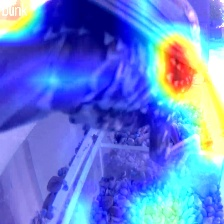

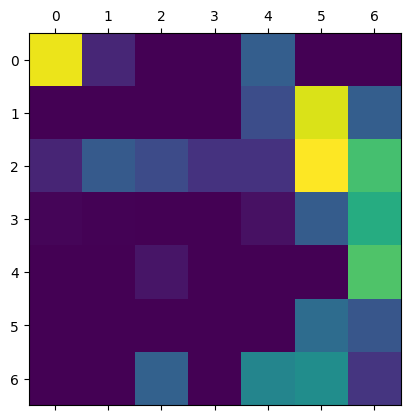

In [76]:
greatPath = "just-bird-data/withBackground/greatTit/(38).jpg"
# unfreeze_layers(model)
greatmat_no_mom = create_heatmap(model=model_res_no_mom, imgpath=starlingFeeder, label=(torch.tensor([5])))
visualize_heatmap_on_top(starlingFeeder, heatmat=greatmat_no_mom, filepath="./great.jpg")

In [107]:
model_base_adam, i_base_adam = load_function("basemodel.tar")
unfreeze_layers(model_base_adam)
print_stats(i_base_adam)

Lowest loss was 0.0664 at epoch 48
Highest accuracy was 1.0000 at epoch 17


In [113]:
starlingFeeder = "feeder-data/starling/starling_738_34.png"
bluetitFeeder = "feeder-data/blueTit/blueTit_401_1.png"
bluetitPath = "just-bird-data/withBackground/blueTit/(6).jpg"
bluetitTensor = torch.tensor([0])
starlingTensor = torch.tensor([6])

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  blueTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


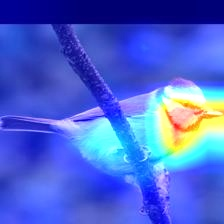

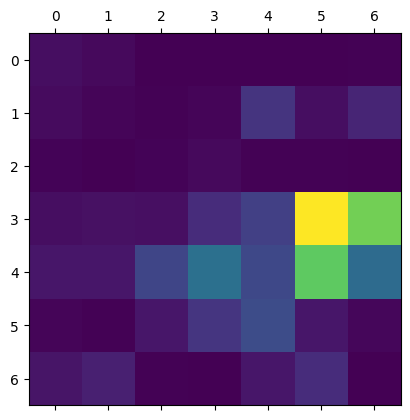

In [109]:
greatmat_base = create_heatmap(model=model_base_adam, imgpath=bluetitPath, label=(torch.tensor([5])))
visualize_heatmap_on_top(bluetitPath, heatmat=greatmat_base, filepath="./great.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  greatTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


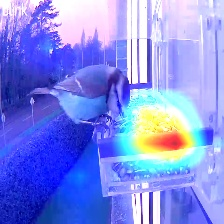

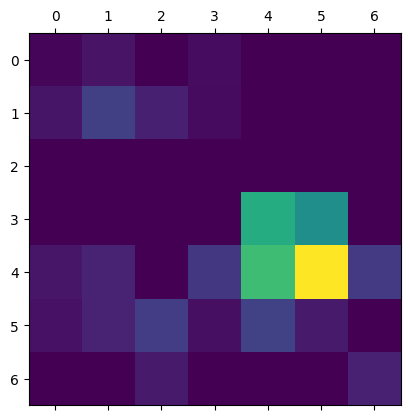

In [114]:
greatmat_base = create_heatmap(model=model_base_adam, imgpath=bluetitFeeder, label=bluetitTensor)
visualize_heatmap_on_top(bluetitFeeder, heatmat=greatmat_base, filepath="./great.jpg")

In [115]:
model_fine, i_fine = load_function("fine_base.tar")
model_fine.eval()
unfreeze_layers(model_fine)
print_stats(i_fine)

Lowest loss was 0.0031 at epoch 9
Highest accuracy was 1.0000 at epoch 2
Number of epochs run  10
Batch size was  16
Optimizer used:  Adam with lr=0.0005
Overall accuracy on test data 99.0476
Overall accuracy on feeder data 58.4256


forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  blueTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


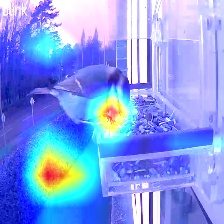

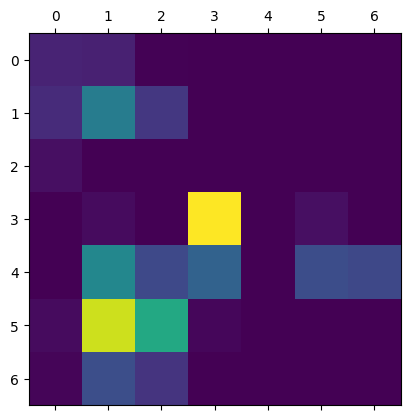

In [116]:
greatmat_fine = create_heatmap(model=model_fine, imgpath=bluetitFeeder, label=bluetitTensor)
visualize_heatmap_on_top(bluetitFeeder, heatmat=greatmat_fine, filepath="./great.jpg")

In [121]:
e, a = top_k_accuracy(dataloader_tiny, model_fine, device)

In [124]:
e

array([5, 1, 0, 3, 3, 5, 2, 0, 3, 5, 6, 0, 0, 4, 4, 4], dtype=int64)

In [125]:
a

array([ -9.065662 , -10.488094 ,  -6.8573213,  -7.534157 ,  -8.629129 ,
        10.723723 ,  -7.1114926,  -3.6016815,   7.0264177,  -8.118107 ,
        -4.670428 ,  -7.556004 ,  -9.275939 ,  -9.990677 ,   6.9335356,
        -7.13324  ,  -6.831143 ,  -8.813408 ,  -5.947215 , -14.2904415,
       -12.756859 ,  -9.283588 ,  -7.7753544, -15.504663 ,   7.0770507,
        -7.4722342,  -9.001562 , -11.019914 , -15.022946 ,  -8.251813 ,
       -19.532936 ,   7.8931584,  -6.7014074, -13.914389 , -16.542295 ,
        -8.921435 ,  -9.567694 , -10.228441 ,  -3.754997 , -11.050458 ,
        11.319338 ,  -8.3441105,  -8.149225 ,  -6.1054063,   7.6758947,
        -6.638782 ,  -7.5539155,  -7.7630296, -10.193743 ,  12.2715645,
        -8.198585 , -12.948224 ,  -9.261017 ,  -5.060243 , -13.91008  ,
       -13.928354 , -11.497846 ,  -4.8940063, -11.305387 ,   7.415588 ,
        -7.715402 ,  -4.586637 , -11.087574 ,  -9.834839 ,  -6.95368  ,
        -8.824874 ,  -6.0081506,  -9.288332 ,  11.042078 , -12.7

In [ ]:
def top_k_accuracy(dataloader: DataLoader, model: models.ResNet, device, k):
    '''
    Gets all labels and predictions for the images in the dataloader 
    '''
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    outlits = torch.zeros(0, device='cpu')
    total_pred =0 
    correct_pred = 0
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            # ee = sklearn.metrics.top_k_accuracy_score(classes, outputs, k=3)
            _, preds = torch.topk(outputs, k)

            for lab, cls in zip(classes, preds.detach().cpu()):
                if lab in cls:
                    correct_pred += 1
                total_pred +=1            
    return correct_pred / total_pred

In [ ]:
top_k_accuracy(dataloader_feeder, model_fine, device, 2)

In [133]:
l,p = labels_and_predictions(dataloader_test, model_fine, device)
accuracy(l,p)

99.04761904761905